In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


## Sky Positions

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from analysis_tools_cython import *
from tqdm import tqdm

In [3]:
def get_output(file_path):
    """Imports batch_analyse output file as pandas dataframe."""
    with open(file_path) as f:
        lines = f.readlines()
    lc_lists = [word for line in lines for word in line.split()]
    lc_lists = [lc_lists[i:i+10] for i in range(0, len(lc_lists), 10)]
    cols = ['file','signal','signal/noise','time','asym_score','width1','width2','duration','depth','transit_prob']
    df = pd.DataFrame(data=lc_lists,columns=cols)
    df[cols[1:-1]] = df[cols[1:-1]].astype('float32')
    return df

def filter_df(df,min_asym_score=1.0,max_asym_score=2.0,duration=0.5,signal=-5.0):
    """filters df for given parameter range.
    Default settings:
    - `signal/noise` greater than 5.
        - Minimum test statistic is always negative. We flip the sign in plots for convenience.
    - `duration` set to greater than 0.5 days.
    - `asym_score` between 1.00 to 2.0.
    """
    return df[(df.duration >= duration) & (df['signal/noise'] <= signal) & (df['asym_score'] >= min_asym_score) & (df['asym_score'] <= max_asym_score)]


In [5]:
df = get_output('output_log/s6_xrp_median.txt')
filtered_df = filter_df(df)
table = Table.from_pandas(df)

In [6]:
sector = 6
path = f'/storage/astro2/phrdhx/tesslcs/tesslcs_sector_{sector}_104'
clip = 3

In [17]:
box = df[(df['signal/noise'] <= -7.4) & (df['asym_score'] >= 1.00) & (df['transit_prob'] == 'maybeTransit') & (df['asym_score'] <= 1.60) & (df['signal/noise'] >= -12)]
to_import = box['file']

In [26]:
box

,file,signal,signal/noise,time,asym_score,width1,width2,duration,depth,transit_prob
6,tesslc_96803704.pkl,-18.672022,-8.696670,1476.597290,1.000481,0.120167,0.063542,0.229170,1237.467041,maybeTransit
179,tesslc_88871058.pkl,-25.408909,-8.887795,1473.474976,1.003194,0.138382,0.043047,0.291663,44.873920,maybeTransit
604,tesslc_156696819.pkl,-16.137440,-7.420001,1473.433228,1.039398,0.026713,0.110795,0.520828,161.488480,maybeTransit
676,tesslc_92011520.pkl,-12.561776,-7.987587,1473.391602,1.044504,0.031104,0.002477,0.062499,766.559998,maybeTransit
747,tesslc_52209792.pkl,-19.092028,-9.790031,1473.474854,1.032564,0.145407,0.028986,0.270827,1053.265991,maybeTransit
...,...,...,...,...,...,...,...,...,...,...
2778439,tesslc_97645778.pkl,-24.784466,-8.091385,1473.474976,1.014396,0.185704,0.048237,0.333330,1202.825562,maybeTransit
2778593,tesslc_156433671.pkl,-25.755253,-7.697842,1473.474854,1.024762,0.185790,0.050683,0.333328,714.429565,maybeTransit
2778661,tesslc_140383101.pkl,-24.255770,-9.085549,1473.474854,1.011227,0.158817,0.039182,0.291663,1410.464722,maybeTransit
2779448,tesslc_92013008.pkl,-23.685541,-10.942654,1473.474976,1.012298,0.133917,0.031873,0.270830,1261.591553,maybeTransit


## Finding the sky distribution of the lightcurves
### In our "interesting box region"

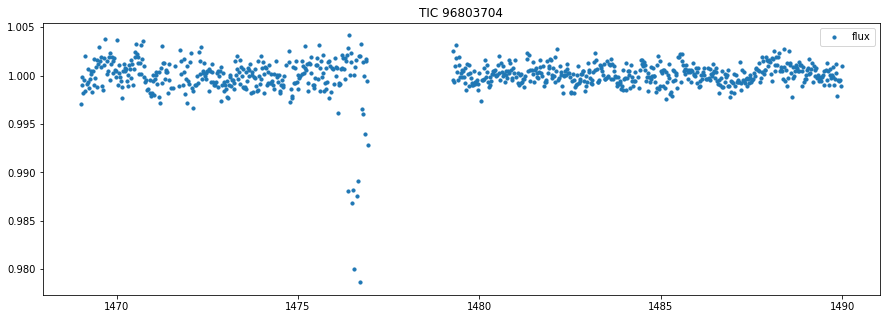

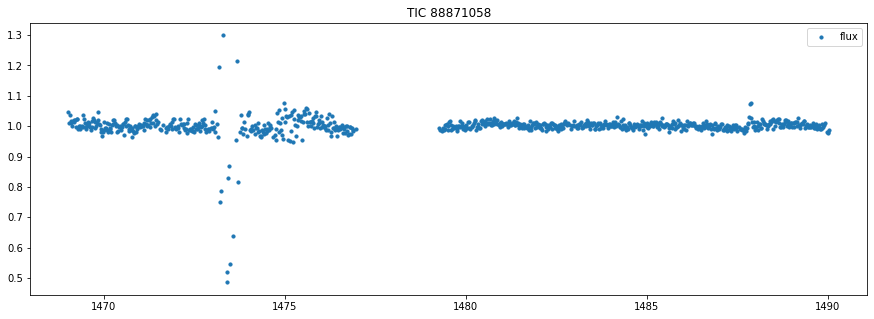

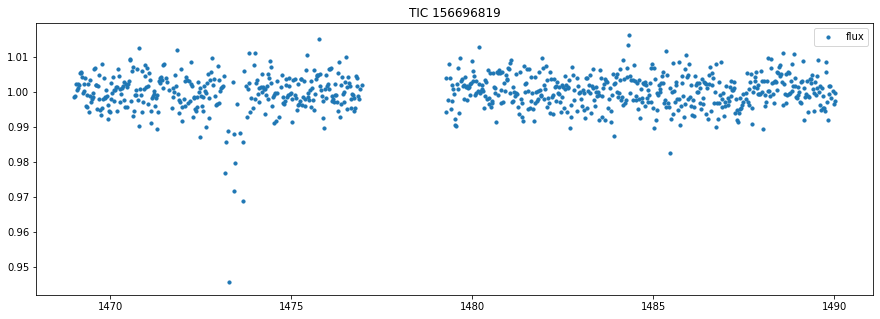

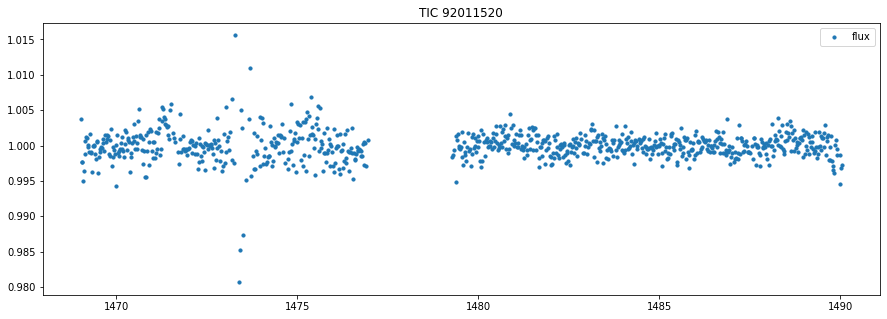

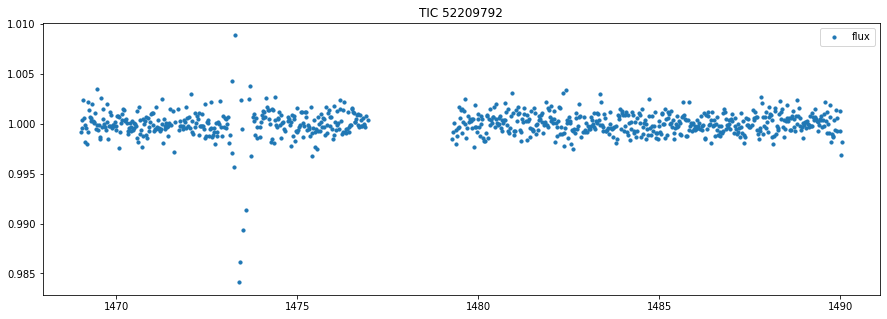

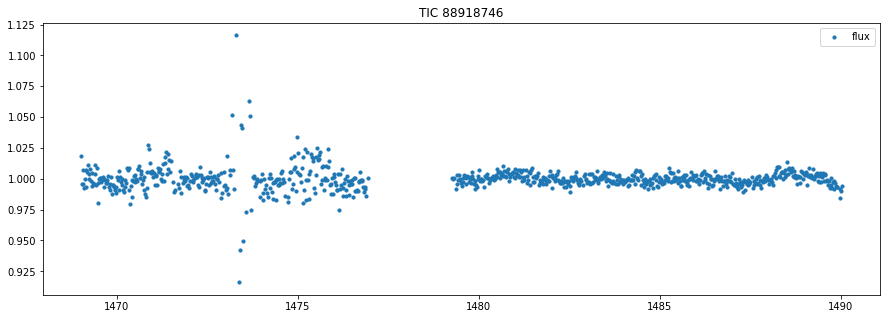

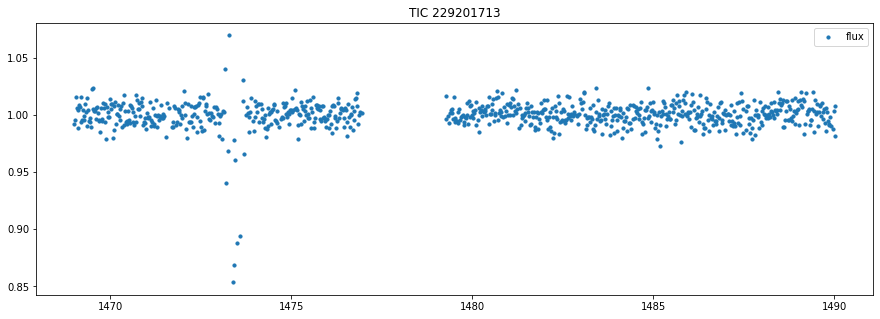

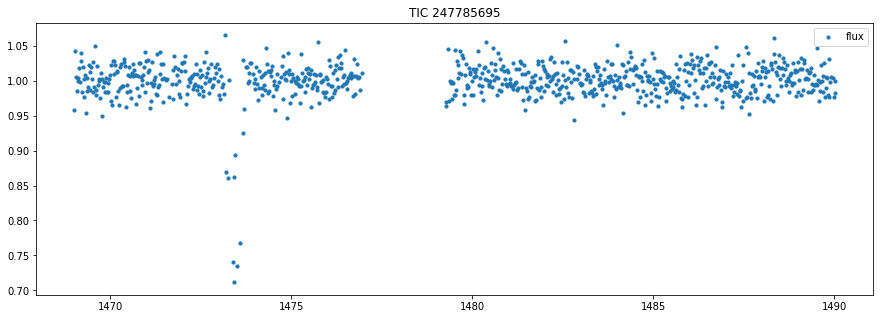

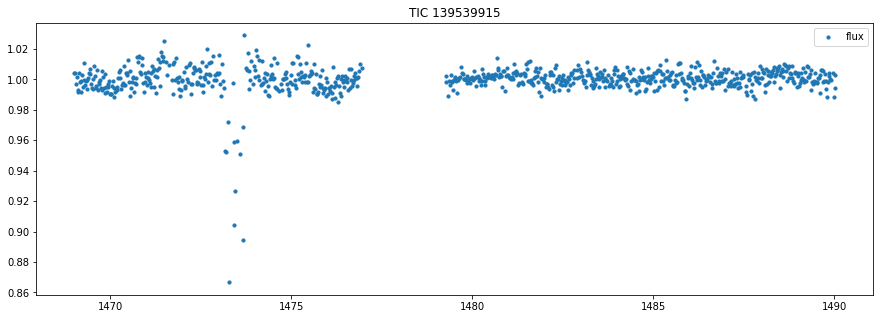

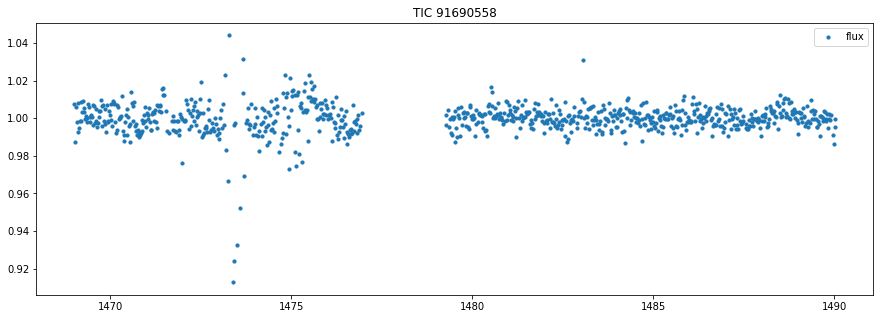

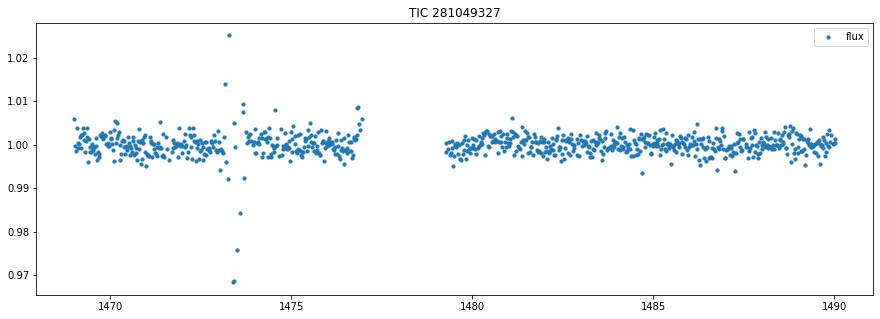

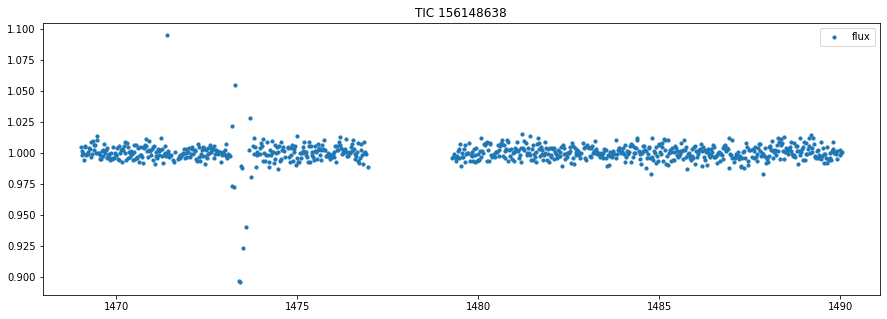

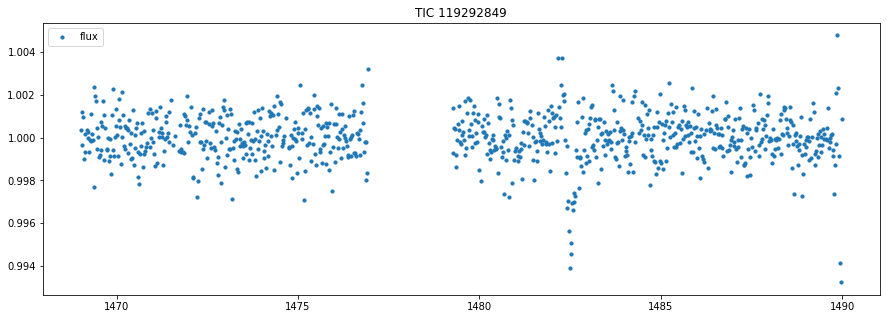

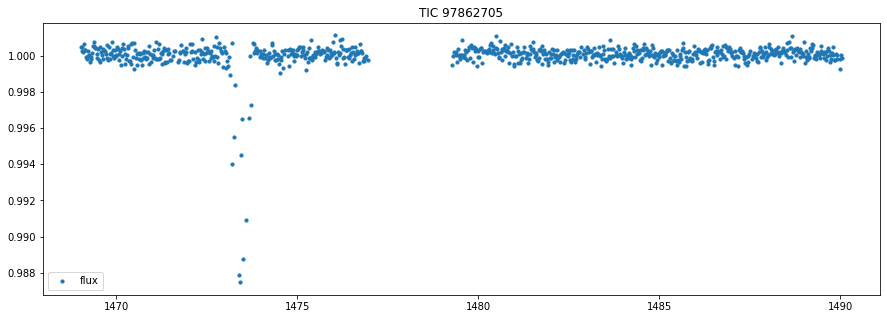

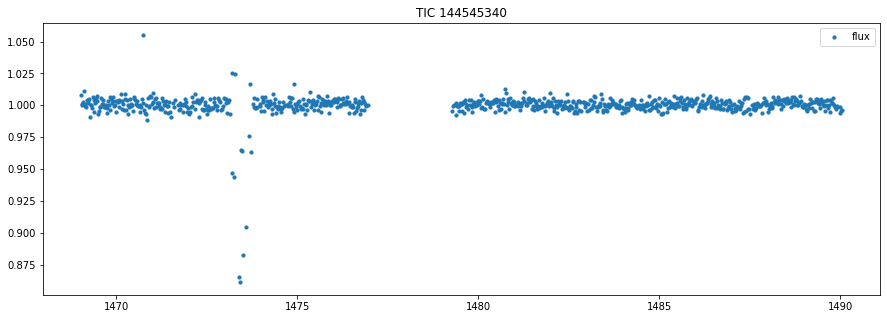

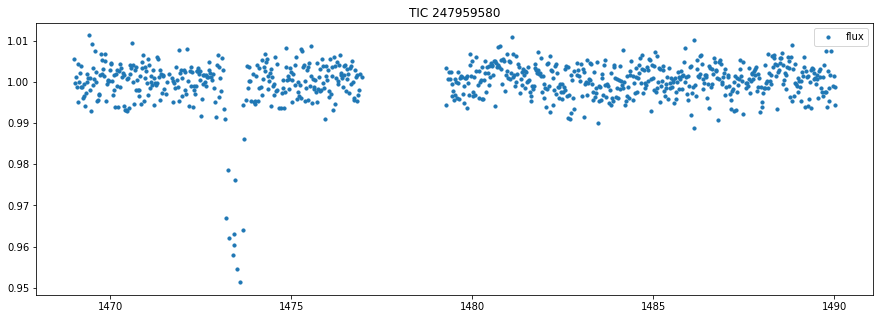

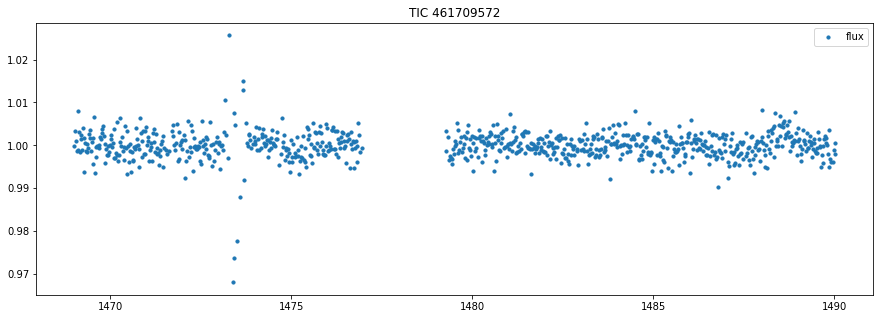

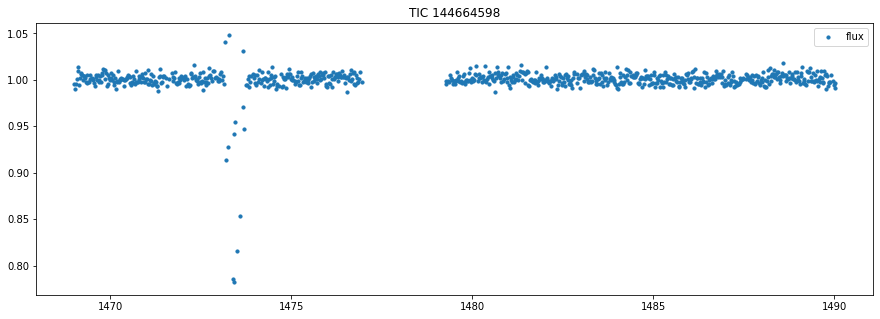

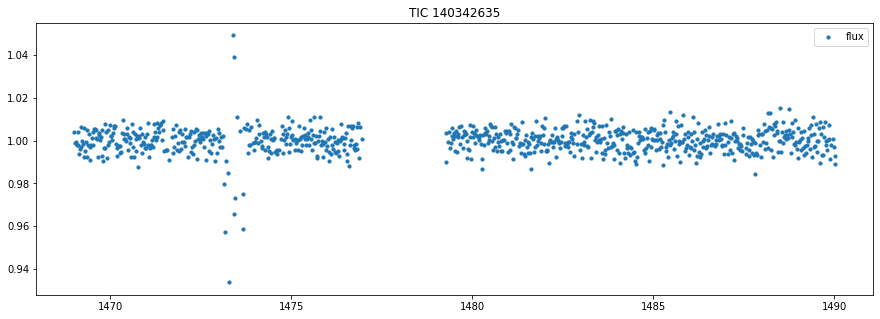

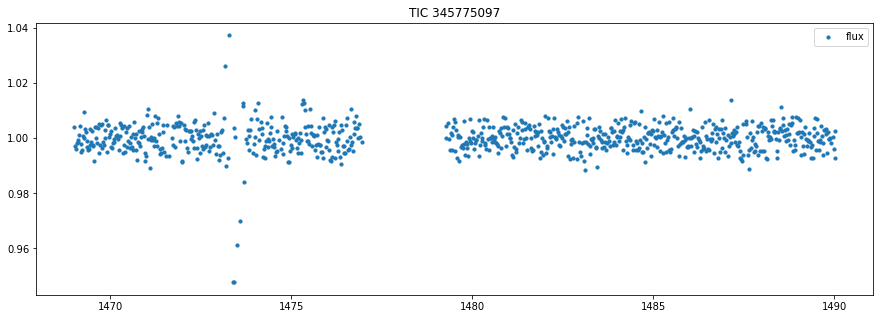

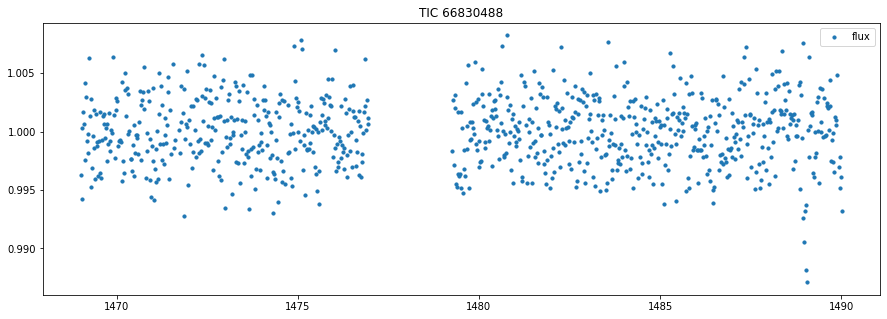

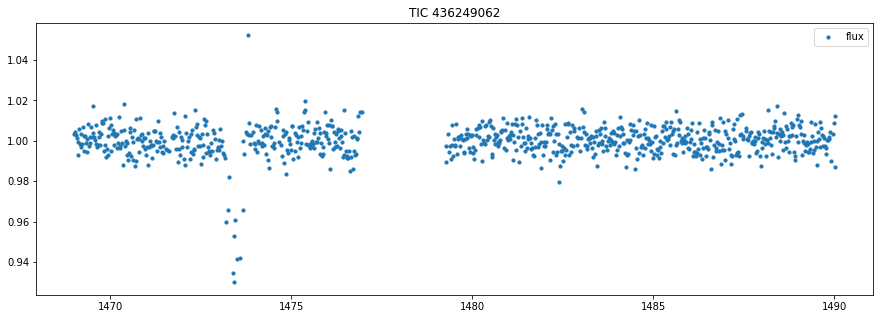

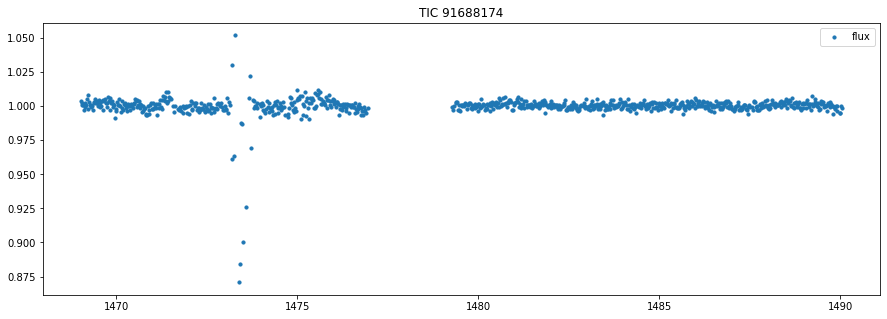

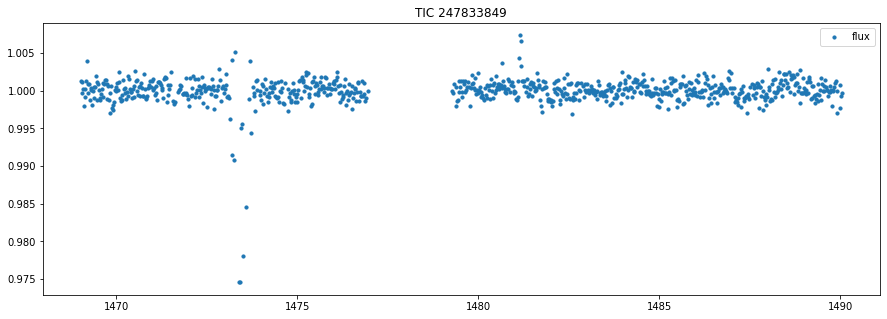

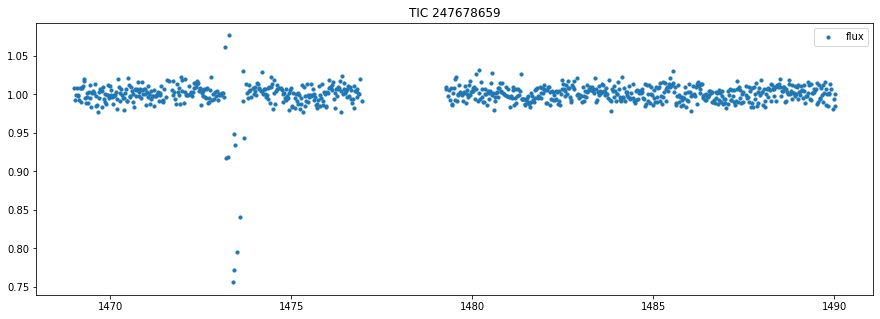

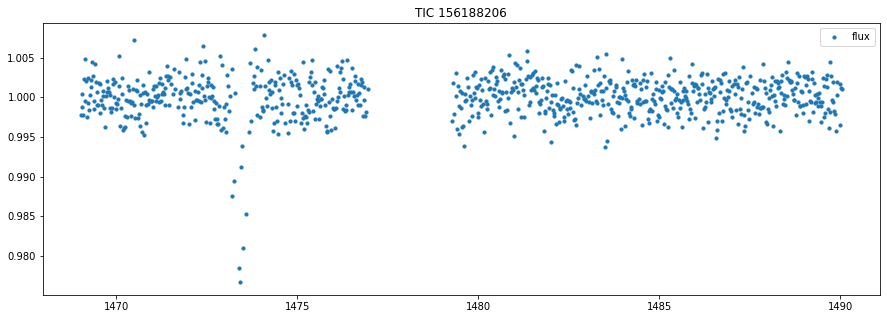

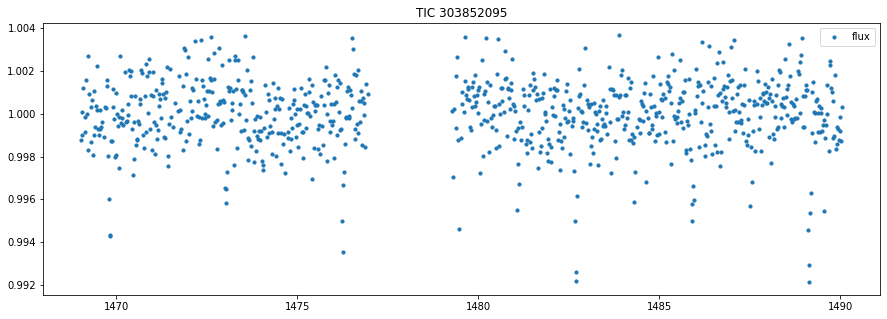

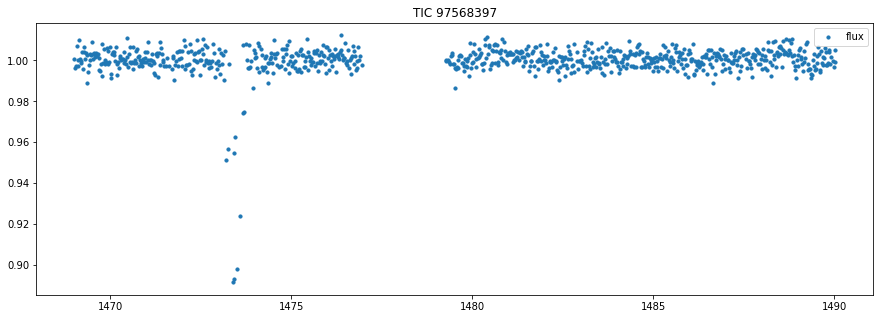

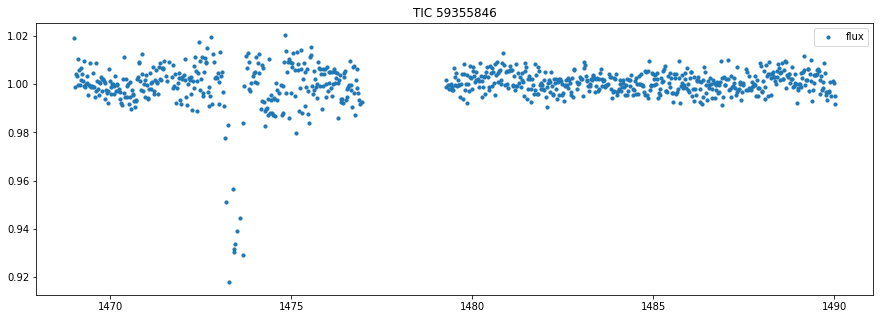

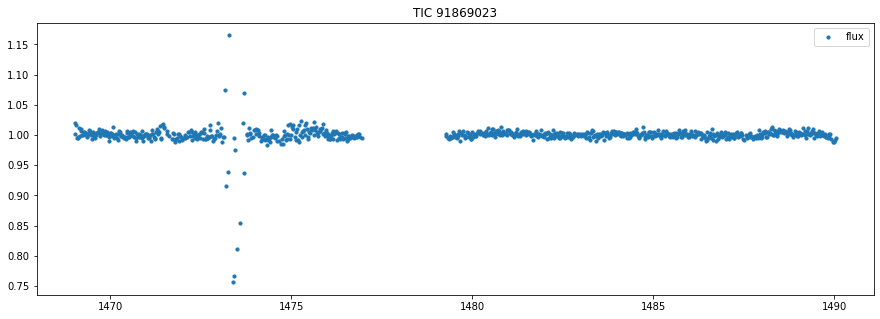

In [28]:
for i in box.file.head(30):
    #file_paths = glob.glob(os.path.join(path2,f'target/**/**/**/**/{i}'))[0]
    file_paths = glob.glob(os.path.join(path,f'**/{i}'))[0]
    #ref = pd.read_pickle(glob.glob(os.path.join(path,f'**/{i}'))[0])
    #table, store = import_lightcurve(file_paths)                     
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=4,drop_bad_points=True)
    camera = store[4]
    tic = store[0]
    chip = store[5]
    fig,ax = plt.subplots(1,figsize=(15,5))

    ax.scatter(table['time'],normalise_lc(table['corrected flux']),s=10,label='flux')
    #ax.scatter(table['time'],sig_clip_array,s=10,c='orange',label='sigma clip to remove outliers')
    #ax.hlines(1-mad,xmin=table['time'][0],xmax=table['time'][-1],label='median line')
    ax.set_title(f"TIC {tic}")
    ax.legend()
    plt.show()
 
    

In [18]:
box_ra_rad = []
box_dec_rad = []
for i in tqdm(to_import.head(100)):
    file_paths = glob.glob(os.path.join(path,f'**/{i}'))[0]
    table, store = import_XRPlightcurve(file_paths,sector=sector,clip=clip,drop_bad_points=True) 
    box_tic = store[0]
    chip = store[5]
    ra = store[1] * u.degree
    dec = store[2] * u.degree
    d = SkyCoord(ra=ra, dec=dec, frame='icrs')
    box_ra_rad.append(d.ra.wrap_at(180 * u.deg).radian)
    box_dec_rad.append(d.dec.radian)

100%|██████████| 100/100 [00:13<00:00,  7.38it/s]


### The rest of the lightcurves

In [30]:
ra_tot[0]

<Quantity 85.44412925 deg>

In [34]:
tic_id = []
ra_tot = []
dec_tot = []
chip = []
for i in tqdm(df.file.head(10000)):
    file_paths = glob.glob(os.path.join(path,f'**/{i}'))[0]
    table,store = import_XRPlightcurve(file_paths,sector=sector,clip=clip,drop_bad_points=True)
    tic = store[0]
    chip.append(store[-1])
    ra_tot.append(store[1] * u.degree)
    dec_tot.append(store[2] * u.degree)

100%|██████████| 10000/10000 [22:42<00:00,  7.34it/s]


In [ ]:
plt.figure(figsize=(12,7))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff projection of Sector 6 and the bad lightcurves")
plt.grid(True)
plt.plot(box_ra_rad, box_dec_rad, 'o', markersize=2, alpha=0.2)
plt.plot(ra_tot[0],dec_tot[0],'y', markersize=2, alpha=0.2)
plt.subplots_adjust(top=0.65,bottom=0.0)
plt.savefig('sky positions.png')

---

In [2]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [3]:
from astroquery.mast import Observations

In [15]:
obsTable = Observations.query_criteria(provenance='QLP',target_name=270577175)

In [18]:
obsTable[-1]['sequence_number']

34